In [ ]:
# 데이터 zip파일 압축 풀기
!unzip './drive/MyDrive/CLASS/week11/data/cats_and_dogs.zip' -d '/content'

In [2]:
from torchvision.io import read_image
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader

In [3]:
# 이미지 데이터 불러오는 함수
class CustomImageDataset(Dataset):
  def __init__(self,img_dir,transform=None):
    self.img_labels = pd.read_csv(f'{img_dir}/label.csv')
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self,idx):
    img_path = f'{self.img_dir}/{self.img_labels.iloc[idx,0]}'
    img = read_image(img_path)
    if self.transform:
      img = self.transform(img)
    label = self.img_labels.iloc[idx,1]
    return img,label

In [4]:
# 이미지 사이즈 단일화 및 augmentation
from torchvision.transforms import transforms, Resize
from torchvision.transforms import RandomCrop,RandomRotation,RandomHorizontalFlip


desired_size = 256
transform = transforms.Compose([
    Resize(size=desired_size),
    RandomCrop(desired_size),
    RandomHorizontalFlip(),
    RandomRotation(degrees=(-45,45))
])

In [5]:
# 데이터셋 정의
train_dataset = CustomImageDataset(
    img_dir = '/content/cats_and_dogs/train',
    transform = transform,
    )

test_dataset = CustomImageDataset(
    img_dir = '/content/cats_and_dogs/test',
    transform = transform
    )

In [6]:
batch_size = 256
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [7]:
# 이미지 확인 함수

def plot_batch(batch, label_dict, cmap=None):
    img_tensor_batch = batch[0]
    label_batch = batch[1]
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img_tensor = img_tensor_batch[i]
        img_array = img_tensor.numpy().transpose(1, 2, 0)
        ax.imshow(img_array, cmap=cmap)
        ax.set_title(f"{label_dict[label_batch[i].item()]}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


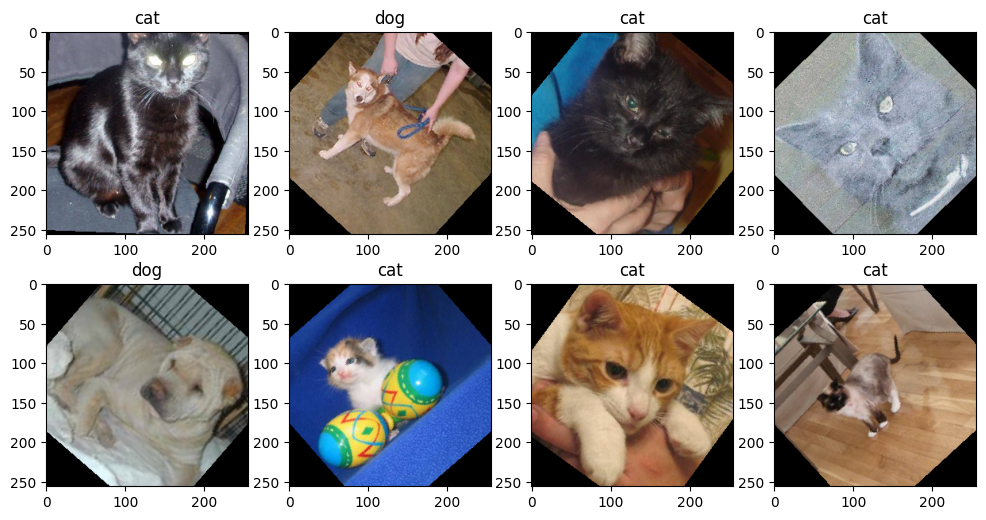

In [8]:
# 레이블 지정 및 확인

from matplotlib import pyplot as plt

label_dict = {0: "cat", 1: "dog"}
for batch in train_dataloader:
    plot_batch(batch, label_dict)
    break

In [ ]:
import torch

class SimpleCNN(torch.nn.Module):
  def __init__(self):
    super(SimpleCNN,self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=3,out_channels=4,kernel_size=3,padding='same')
    self.conv2 = torch.nn.Conv2d(in_channels=4,out_channels=8,kernel_size=3,padding='same')
    self.conv3 = torch.nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding='same')
    self.fc = torch.nn.Linear(in_features=16384, out_features=10)
    self.pool = torch.nn.MaxPool2d(2,2)
    self.activation = torch.nn.ReLU()

  def forward(self,x):
    x = self.pool(self.activation(self.conv1(x)))
    x = self.pool(self.activation(self.conv2(x)))
    x = self.pool(self.activation(self.conv3(x)))
    x = torch.flatten(x,1)
    x = self.fc(x)
    return x

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device).float()
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(test_dataloader):
        x_val = x_val.to(device).float()
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [ ]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 15

In [ ]:
logs = train_validate_model(model)

100%|██████████| 8/8 [00:19<00:00,  2.49s/it]


epoch 1 train - loss: 1.6382 acc: 0.5076 val - loss: 0.76 acc: 0.5056


100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


epoch 2 train - loss: 0.6824 acc: 0.5773 val - loss: 0.6616 acc: 0.5933


100%|██████████| 8/8 [00:22<00:00,  2.76s/it]


epoch 3 train - loss: 0.654 acc: 0.616 val - loss: 0.6503 acc: 0.6309


100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


epoch 4 train - loss: 0.6459 acc: 0.6267 val - loss: 0.6449 acc: 0.6334


100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


epoch 5 train - loss: 0.6341 acc: 0.6404 val - loss: 0.6372 acc: 0.6283


100%|██████████| 8/8 [00:19<00:00,  2.45s/it]


epoch 6 train - loss: 0.6207 acc: 0.6572 val - loss: 0.6216 acc: 0.6583


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


epoch 7 train - loss: 0.609 acc: 0.6671 val - loss: 0.6213 acc: 0.6599


100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


epoch 8 train - loss: 0.6066 acc: 0.6715 val - loss: 0.6051 acc: 0.6664


100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


epoch 9 train - loss: 0.5977 acc: 0.6871 val - loss: 0.6004 acc: 0.6867


100%|██████████| 8/8 [00:19<00:00,  2.50s/it]


epoch 10 train - loss: 0.5811 acc: 0.6998 val - loss: 0.5879 acc: 0.6856


100%|██████████| 8/8 [00:19<00:00,  2.48s/it]


epoch 11 train - loss: 0.5745 acc: 0.7028 val - loss: 0.6119 acc: 0.6763


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


epoch 12 train - loss: 0.578 acc: 0.7032 val - loss: 0.5907 acc: 0.6905


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


epoch 13 train - loss: 0.5763 acc: 0.7069 val - loss: 0.6156 acc: 0.6614


100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


epoch 14 train - loss: 0.5766 acc: 0.6995 val - loss: 0.5675 acc: 0.7036


100%|██████████| 8/8 [00:18<00:00,  2.37s/it]

epoch 15 train - loss: 0.5689 acc: 0.7114 val - loss: 0.5777 acc: 0.7048


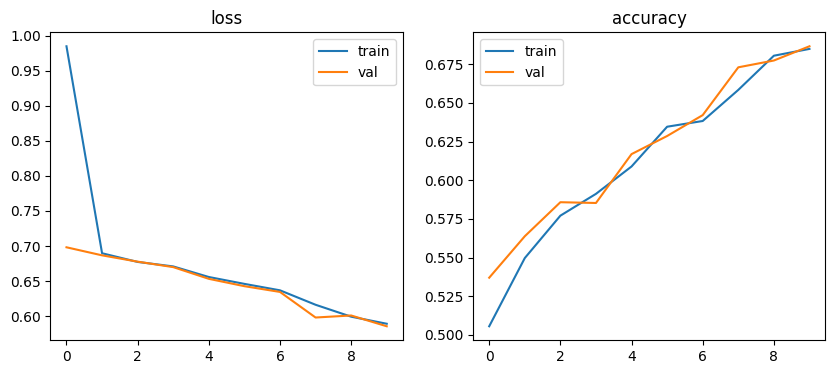

In [ ]:
plot_logs(logs)